# Assignment 2 CH5650

## Vanilla Approach

### Importing the dependencies

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)

### Making a class for better control

In [2]:
class ModelTrainer:
    def __init__(self, data, target_column, test_size=0.4, random_state=42):
        self.data = data
        self.target_column = target_column
        self.test_size = test_size
        self.random_state = random_state
        self.model_details = {}
        self.X = data.drop(columns=[target_column])
        self.y = data[target_column]
        self._preprocess_data()

    def _preprocess_data(self):
        self.scaler_y = StandardScaler()
        self.y_scaled = self.scaler_y.fit_transform(self.y.values.reshape(-1, 1)).flatten()

        self.X_train, self.X_temp, self.y_train, self.y_temp = train_test_split(self.X, self.y_scaled, test_size=self.test_size, random_state=self.random_state)
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(self.X_temp, self.y_temp, test_size=0.5, random_state=self.random_state)

    def linear_regression(self):
        linear_model = LinearRegression()
        linear_model.fit(self.X_train, self.y_train)
        y_val_pred = linear_model.predict(self.X_val)
        y_test_pred = linear_model.predict(self.X_test)
        
        self.model_details['linear_regression'] = {
            'model': linear_model,
            'validation': self._evaluate_model(self.y_val, y_val_pred),
            'test': self._evaluate_model(self.y_test, y_test_pred),
            'val_predictions': y_val_pred,
            'val_actuals': self.y_val
        }

    def polynomial_regression(self, degree=2):
        poly_features = PolynomialFeatures(degree=degree)
        X_train_poly = poly_features.fit_transform(self.X_train)
        X_val_poly = poly_features.transform(self.X_val)
        X_test_poly = poly_features.transform(self.X_test)
        poly_model = LinearRegression()
        poly_model.fit(X_train_poly, self.y_train)

        y_val_pred_poly = poly_model.predict(X_val_poly)
        y_test_pred_poly = poly_model.predict(X_test_poly)
        
        self.model_details['polynomial_regression'] = {
            'model': poly_model,
            'validation': self._evaluate_model(self.y_val, y_val_pred_poly),
            'test': self._evaluate_model(self.y_test, y_test_pred_poly),
            'val_predictions': y_val_pred_poly,
            'val_actuals': self.y_val
        }

    def random_forest_regression(self, n_estimators=100, max_depth=None):
        rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=self.random_state)
        rf_model.fit(self.X_train, self.y_train)
        
        y_val_pred_rf = rf_model.predict(self.X_val)
        y_test_pred_rf = rf_model.predict(self.X_test)
        
        self.model_details['random_forest_regression'] = {
            'model': rf_model,
            'validation': self._evaluate_model(self.y_val, y_val_pred_rf),
            'test': self._evaluate_model(self.y_test, y_test_pred_rf),
            'val_predictions': y_val_pred_rf,
            'val_actuals': self.y_val
        }

    def _evaluate_model(self, y_true, y_pred):
        y_pred_original = self.scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_true_original = self.scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()

        mae = mean_absolute_error(y_true_original, y_pred_original)
        mse = mean_squared_error(y_true_original, y_pred_original)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true_original, y_pred_original)

        return {'mae': mae,'mse': mse,'rmse': rmse,'r2': r2}

    def get_model_details(self):
        model_metrics = []
        for model_name, results in self.model_details.items():
            validation_metrics = results['validation']
            test_metrics = results['test']
            
            model_metrics.append({'Model': model_name,'Validation MAE': validation_metrics['mae'],'Validation MSE': validation_metrics['mse'],
                'Validation RMSE': validation_metrics['rmse'],'Validation R²': validation_metrics['r2'],'Test MAE': test_metrics['mae'],
                'Test MSE': test_metrics['mse'],'Test RMSE': test_metrics['rmse'],'Test R²': test_metrics['r2']
            })
        model_metrics_df = pd.DataFrame(model_metrics)
        return model_metrics_df

    def print_validation_results(self):
        for model_name, results in self.model_details.items():
            print(f"Model: {model_name}")
            val_actuals = self.scaler_y.inverse_transform(results['val_actuals'].reshape(-1, 1)).flatten().round(2)
            val_predictions = self.scaler_y.inverse_transform(results['val_predictions'].reshape(-1, 1)).flatten().round(2)
            validation_df = pd.DataFrame({'Actual': val_actuals,'Predicted': val_predictions})
            print(validation_df.head(5))
            print()

#### Fetching data and initializing the class

In [3]:
data = pd.read_csv('alloy-confp-train-data.csv')
trainer_class = ModelTrainer(data, 'HV')

In [4]:
data = data.drop(['ID'], axis=1)
data.head()

,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni
0,170,0.056604,0.000000,0.188679,0.188679,0.188679,0.377358
1,380,0.200000,0.266667,0.000000,0.000000,0.266667,0.266667
2,775,0.400000,0.200000,0.200000,0.000000,0.200000,0.000000
3,486,0.208333,0.000000,0.208333,0.208333,0.208333,0.166667
4,118,0.024390,0.243902,0.243902,0.000000,0.243902,0.243902


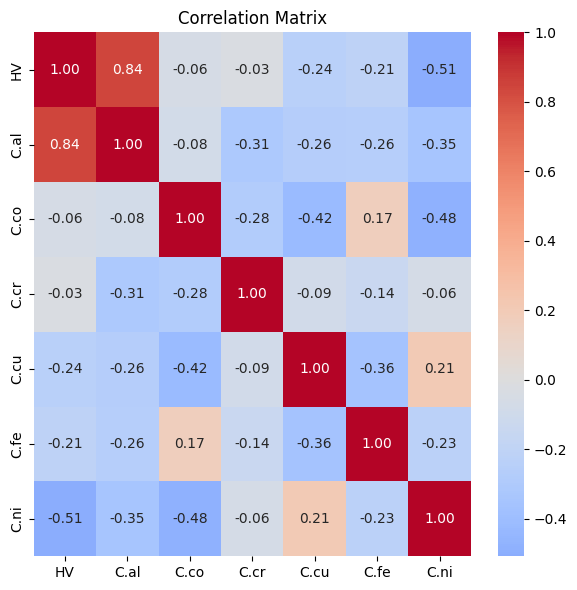

In [5]:
matrix = data.corr()
plt.figure(figsize=(6, 6))
sns.heatmap(matrix, annot=True,cmap='coolwarm',fmt='.2f',center=0)             
plt.title('Correlation Matrix')
plt.tight_layout()


### Calling the different models

##### Here we are simply using the mole-fraction as an input to get the final hardness. It does not take into account the possible structure disparities (no information about the microstructures)

In [12]:
trainer_class.linear_regression()
trainer_class.polynomial_regression(degree=2)
trainer_class.random_forest_regression(n_estimators=100, max_depth=2)
model_details = trainer_class.get_model_details()

#### Printing the model details of every model

In [13]:
print(model_details)

                      Model  Validation MAE  Validation MSE  Validation RMSE  \
0         linear_regression       23.326385      754.603621        27.470050   
1     polynomial_regression       22.527327      893.343505        29.888853   
2  random_forest_regression       32.215563     1991.924013        44.630976   

   Validation R²   Test MAE     Test MSE  Test RMSE   Test R²  
0       0.981997  26.754077  1008.073783  31.750178  0.974101  
1       0.978687  20.882749   685.910987  26.189902  0.982378  
2       0.952478  26.116266  1031.468857  32.116489  0.973500  


#### Printing the validation details of all the models

In [14]:
trainer_class.print_validation_results()

Model: linear_regression
   Actual  Predicted
0   338.0     310.30
1   620.0     639.57
2   158.0     162.89
3   140.0     136.41
4   382.0     352.55

Model: polynomial_regression
   Actual  Predicted
0   338.0     337.89
1   620.0     645.53
2   158.0     158.45
3   140.0     100.55
4   382.0     378.33

Model: random_forest_regression
   Actual  Predicted
0   338.0     322.56
1   620.0     626.95
2   158.0     171.68
3   140.0     171.68
4   382.0     348.29



### Introducing new features based on the microstructures

## More informed network

In [15]:
import pandas as pd
import numpy as np
from pymatgen.core.periodic_table import Element

# Read the data
df = pd.read_csv("alloy-confp-train-data.csv")

# Define element properties
elements = ['Al', 'Co', 'Cr', 'Cu', 'Fe', 'Ni']
atomic_radii = {el: Element(el).atomic_radius for el in elements}
electroneg = {el: Element(el).X for el in elements}
valence = {'Al': 3, 'Co': 9, 'Cr': 6, 'Cu': 11, 'Fe': 8, 'Ni': 10}

def calculate_features(row):
    # Get concentrations
    conc = {
        'Al': row['C.al'], 'Co': row['C.co'], 'Cr': row['C.cr'],
        'Cu': row['C.cu'], 'Fe': row['C.fe'], 'Ni': row['C.ni']
    }
    
    avg_radius = sum(conc[el] * atomic_radii[el] for el in elements)
    delta_r = np.sqrt(sum(conc[el] * (1-atomic_radii[el]/avg_radius)**2 for el in elements))
    
    avg_chi = sum(conc[el] * electroneg[el] for el in elements)
    delta_chi = np.sqrt(sum(conc[el] * (electroneg[el] - avg_chi)**2 for el in elements))
    
    vec = sum(conc[el] * valence[el] for el in elements)
    
    entropy = -8.314 * sum(conc[el] * np.log(conc[el]) for el in elements if conc[el] > 0)
    
    enthalpy = sum(conc[el1] * conc[el2] * 4 
                  for i, el1 in enumerate(elements) 
                  for el2 in elements[i+1:])
    
    return pd.Series({
        'delta_r': delta_r,
        'delta_chi': delta_chi,
        'VEC': vec,
        'entropy': entropy,
        'enthalpy': enthalpy
    })

# Calculate all features
features = df.apply(calculate_features, axis=1)

# Combine with original data
feature_columns = ['delta_r', 'delta_chi', 'VEC', 'entropy', 'enthalpy']
X_raw = pd.concat([df[['C.al', 'C.co', 'C.cr', 'C.cu', 'C.fe', 'C.ni']], features[feature_columns]], axis=1)

raw_df = pd.concat([X_raw, df['HV']], axis=1)
print(raw_df.head())

# Apply StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# Convert to DataFrame with column names for better interpretability
X = pd.DataFrame(X, columns=X_raw.columns)
y = df['HV']

df_final = pd.concat([X, y], axis=1)


       C.al      C.co      C.cr      C.cu      C.fe      C.ni   delta_r  \
0  0.056604  0.000000  0.188679  0.188679  0.188679  0.377358  0.026803   
1  0.200000  0.266667  0.000000  0.000000  0.266667  0.266667  0.038120   
2  0.400000  0.200000  0.200000  0.000000  0.200000  0.000000  0.050995   
3  0.208333  0.000000  0.208333  0.208333  0.208333  0.166667  0.041409   
4  0.024390  0.243902  0.243902  0.000000  0.243902  0.243902  0.022836   

   delta_chi       VEC    entropy  enthalpy   HV  
0   0.107382  8.660377  12.257257  1.495194  170  
1   0.109390  7.800000  11.467436  1.493333  380  
2   0.114438  5.800000  11.075737  1.440000  775  
3   0.123884  7.500000  13.350675  1.597222  486  
4   0.100853  8.121951  12.197865  1.522903  118  


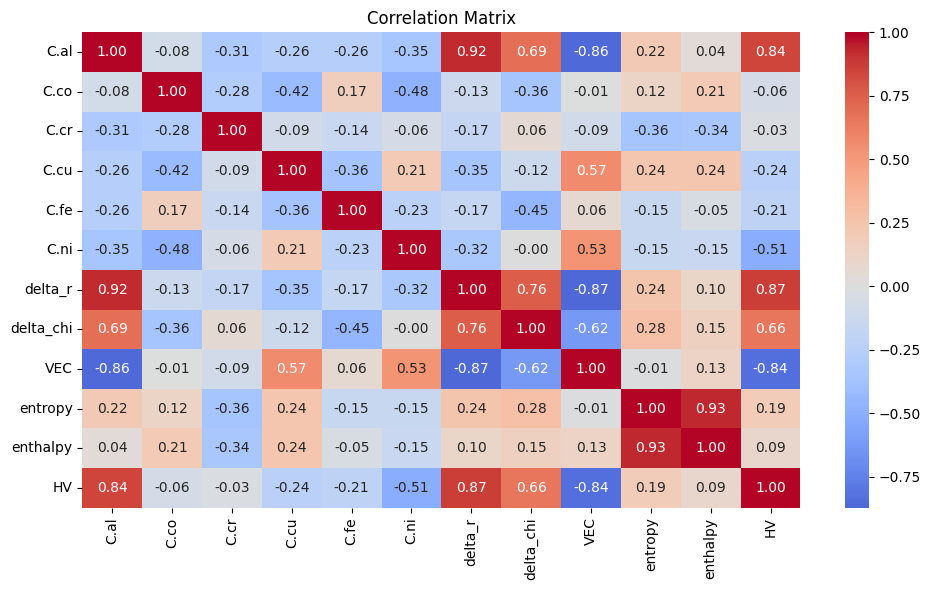

In [16]:
matrix2 = raw_df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(matrix2, annot=True,cmap='coolwarm',fmt='.2f',center=0)             
plt.title('Correlation Matrix')
plt.tight_layout()

In [17]:
physics_based = ModelTrainer(df_final, 'HV')

In [18]:
physics_based.linear_regression()
physics_based.polynomial_regression(degree=3)
physics_based.random_forest_regression(n_estimators=50, max_depth=10)
model_details = physics_based.get_model_details()

In [19]:
print(model_details)

                      Model  Validation MAE  Validation MSE  Validation RMSE  \
0         linear_regression       71.819027    8.343681e+03        91.343751   
1     polynomial_regression   214077.481593    1.594243e+11    399279.784769   
2  random_forest_regression       76.978668    1.039488e+04       101.955271   

   Validation R²       Test MAE      Test MSE      Test RMSE       Test R²  
0   8.009399e-01      67.772847  6.907987e+03      83.114301  8.225243e-01  
1  -3.803479e+06  297124.517203  3.028990e+11  550362.579362 -7.781888e+06  
2   7.520033e-01      47.161242  2.845565e+03      53.343835  9.268935e-01  


In [20]:
physics_based.print_validation_results()

Model: linear_regression
   Actual  Predicted
0   338.0     442.12
1   620.0     438.48
2   158.0     127.50
3   140.0     194.12
4   382.0     395.61

Model: polynomial_regression
   Actual  Predicted
0   338.0    1266.97
1   620.0  -42446.16
2   158.0  -80139.65
3   140.0   35946.29
4   382.0 -124614.46

Model: random_forest_regression
   Actual  Predicted
0   338.0     513.31
1   620.0     329.92
2   158.0     158.14
3   140.0     190.22
4   382.0     275.42

